In [ ]:
# Notatnik ewaluacyjny do pracy magisterskiej

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Zbior danych
import kagglehub

# Pobranie datasetu za pomocą kagglehub
data = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

# Ścieżka do danych (zmodyfikowana na katalog z "color"w dodatkowym folderze)
data = os.path.join(data, "plantvillage dataset/color")

# Sprawdzenie, czy dane zostały poprawnie załadowane
if not os.path.exists(data):
    print(f"Folder danych nie istnieje: {data}")
else:
    print(f"Dane znajdują się w folderze: {data}")

# Funkcja do tworzenia DataFrame z obrazami i etykietami
def create_dataframe(data_path):
    filepaths = []  # Lista na ścieżki do plików
    labels = []  # Lista na etykiety

    folds = os.listdir(data_path)  # Lista podfolderów (klas)

    for fold in folds:
        f_path = os.path.join(data_path, fold)  # Ścieżka do folderu klasy
        imgs = os.listdir(f_path)  # Lista obrazów w folderze

        for img in imgs:
            img_path = os.path.join(f_path, img)  # Ścieżka do obrazu
            filepaths.append(img_path)  # Dodanie ścieżki do listy
            labels.append(fold)  # Dodanie etykiety (nazwa folderu)

    # Tworzenie DataFrame z list
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Tworzenie DataFrame z danymi
df = create_dataframe(data)

# Wyświetlenie pierwszych 5 wierszy DataFrame
print(df.head())

Dane znajdują się w folderze: /kaggle/input/plantvillage-dataset/plantvillage dataset/color
                                           Filepaths                Labels
0  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
1  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
2  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
3  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
4  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight


In [ ]:
# Zmniejszenie zbioru danych do 40%
# reduced_df = df.sample(frac=0.4, random_state=42)

# Podział danych na zbiory treningowy, walidacyjny i testowy
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

bs=4 #bath size

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False
)

Found 5431 validated image filenames belonging to 38 classes.


In [ ]:
# Załaduj model
model = load_model('/content/drive/MyDrive/praca_magisterska/wyniki/model_xception.h5')


In [ ]:
# Przewidujemy na danych testowych
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 873s 642ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Dokładność (accuracy)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision, recall, f1
precision = precision_score(y_true, y_pred, average='weighted')  # lub 'macro' w zależności od potrzeb
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision (średnia ważona): {precision:.4f}")
print(f"Recall (średnia ważona):    {recall:.4f}")
print(f"F1-score (średnia ważona):  {f1:.4f}")

# Szczegółowy raport dla każdej klasy
print("\nPełny raport klasyfikacji:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Accuracy: 0.9713
Precision (średnia ważona): 0.9746
Recall (średnia ważona):    0.9713
F1-score (średnia ważona):  0.9714

Pełny raport klasyfikacji:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        63
                                 Apple___Black_rot       1.00      1.00      1.00        56
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        21
                                   Apple___healthy       0.99      0.99      0.99       135
                               Blueberry___healthy       0.98      0.99      0.99       167
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       111
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        77
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.82      0.88        51
                     

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

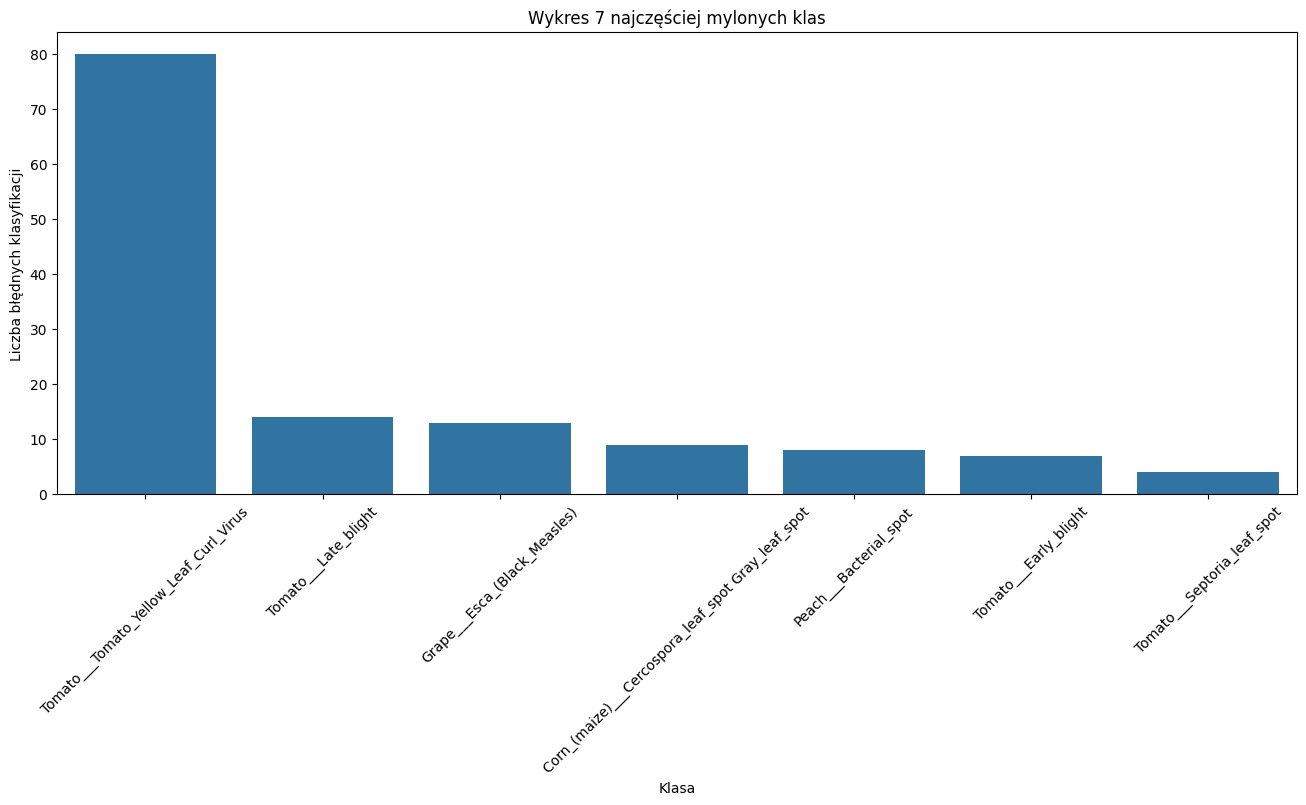

In [ ]:
# Zerowanie trafnych klasyfikacji, by zobaczyć pomyłki
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Najczęściej mylone klasy
most_confused = cm_no_diag.sum(axis=1)
top5_idx = np.argsort(most_confused)[-7:][::-1]
top5_labels = [class_labels[i] for i in top5_idx]

# Wykres - 7 najczęściej mylonych klas
plt.figure(figsize=(16,6))
sns.barplot(x=top5_labels, y=most_confused[top5_idx])
plt.title("Wykres 7 najczęściej mylonych klas")
plt.xlabel("Klasa")
plt.xticks(rotation=45)
plt.ylabel("Liczba błędnych klasyfikacji")
plt.show()

In [ ]:
# Najczęściej mylona klasa i z czym była mylona
worst_idx = top5_idx[0]
confused_with_idx = np.argmax(cm_no_diag[worst_idx])
true_label = class_labels[worst_idx]
pred_label = class_labels[confused_with_idx]

print(f"Najczęściej mylona klasa: {true_label}")
print(f"Najczęściej mylona z: {pred_label}")


Najczęściej mylona klasa: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Najczęściej mylona z: Soybean___healthy


Najczęściej mylona klasa: Tomato___Tomato_Yellow_Leaf_Curl_Virus
- Mylona z: Soybean___healthy (78 razy)
- Mylona z: Corn_(maize)___healthy (2 razy)
- Mylona z: Tomato___Tomato_Yellow_Leaf_Curl_Virus (0 razy)
- Mylona z: Tomato___Target_Spot (0 razy)
- Mylona z: Tomato___healthy (0 razy)


/tmp/ipython-input-34-3809374841.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_confused_with_labels, y=top_confused_with_counts, palette='Reds_r')


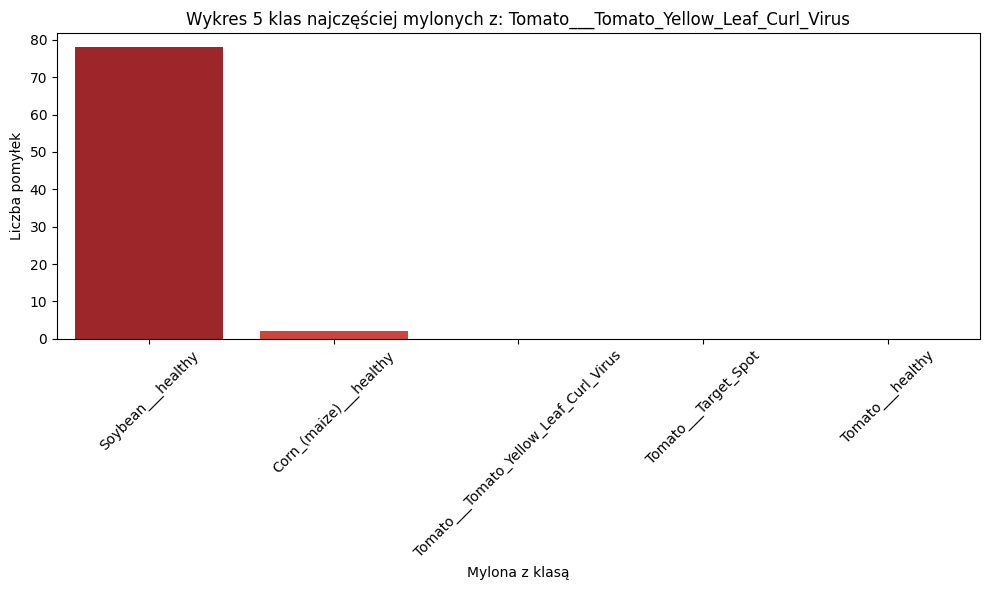

In [ ]:
# Najczęściej mylona klasa
worst_idx = top5_idx[0]
true_label = class_labels[worst_idx]

# Z czym była mylona najczęściej – TOP 5
confusion_row = cm_no_diag[worst_idx]
top_confused_with_idx = np.argsort(confusion_row)[-5:][::-1]
top_confused_with_counts = confusion_row[top_confused_with_idx]
top_confused_with_labels = [class_labels[i] for i in top_confused_with_idx]

# Wypisanie
print(f"Najczęściej mylona klasa: {true_label}")
for i in range(5):
    print(f"- Mylona z: {top_confused_with_labels[i]} ({top_confused_with_counts[i]} razy)")

# Wykres
plt.figure(figsize=(10,6))
sns.barplot(x=top_confused_with_labels, y=top_confused_with_counts, palette='Reds_r')
plt.title(f"Wykres 5 klas najczęściej mylonych z: {true_label}")
plt.xlabel("Mylona z klasą")
plt.ylabel("Liczba pomyłek")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


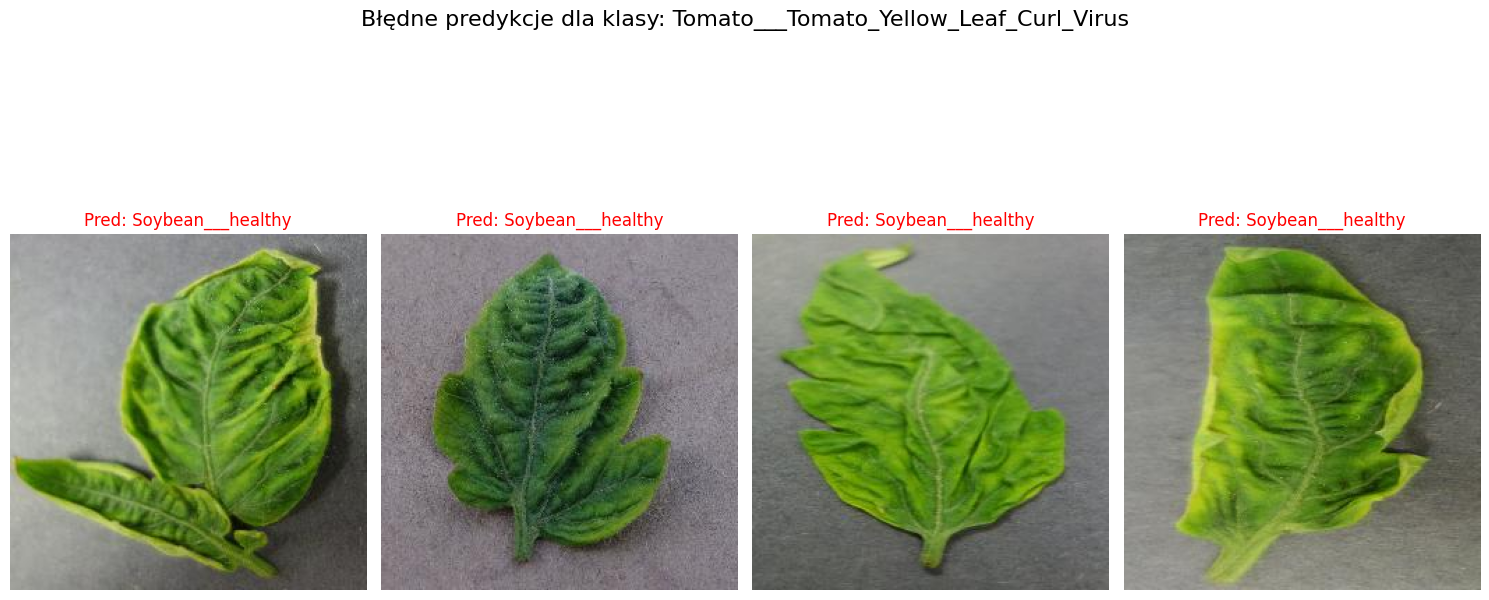

In [ ]:
import cv2

# Licznik wyświetlonych obrazów
count = 0
max_images = 4

plt.figure(figsize=(15, 8))

for i in range(len(y_true)):
    if y_true[i] == worst_idx and y_pred[i] != y_true[i]:
        img_path = test_generator.filepaths[i]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, max_images, count + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        # GT: {true_label}\n
        plt.title(f"Pred: {pred_label}", color='red', fontsize=12)

        count += 1
        if count == max_images:
            break

plt.suptitle(f"Błędne predykcje dla klasy: {true_label}", fontsize=16)
plt.tight_layout()
plt.show()